# Multi Instrument Example -- Sparse Matrix Method

## Setup AIA Inputs

### Import Statements

In [1]:
#%pip install astropy scipy ipympl ndcube xrtpy sunpy lxml drms zeep
from IPython.display import display, HTML
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))

from sys import path
import os, importlib, numpy as np, astropy.units as u, matplotlib as mpl, matplotlib.pyplot as plt
from astropy.time import Time
mpl.use("Agg")

# Enable interactive plotting with widgets
%matplotlib widget

# Set matplotlib parameters for better visualization
plt.rcParams.update({'image.origin': 'lower'})
np.set_printoptions(linewidth=128)

# Define base path and append EMToolKit path
base_path = os.getcwd(); path.append(base_path)

# import EMToolKit and its visualization module
import EMToolKit, EMToolKit.visualization.dashboard, EMToolKit.EMToolKit as emtk
from EMToolKit.instruments.xrt import xrt_wrapper
from EMToolKit.algorithms.sparse_matrix_dem_wrapper import sparse_matrix_dem_wrapper

# Initialize an empty EM collection
em_collection = 0

In [2]:
# These flags tell the program not to recalculate the data if it has already been calculated
redownload = False

### Download the Imagery

In [3]:
from EMToolKit.instruments.aia import download_sdo_data
from EMToolKit.instruments.xrt import download_xrt_data

date='2010-07-25T17:58:44'

# Download the data
aia_paths, sdo_data_dir = download_sdo_data(os.path.join(base_path,'data','2010-07-25T17_58_44'), date, redownload=redownload)
xrt_paths, xrt_data_dir = download_xrt_data(os.path.join(base_path,'data','2010-07-25T17_58_44'), date, redownload=redownload)
paths = aia_paths + xrt_paths

Found 6 AIA images on disk.
Found 3 xrt images on disk.


### Load and Crop the Imagery

In [4]:
from EMToolKit.instruments.aia import load_from_paths, aia_wrapper

xl, yl, = 240*u.arcsec, -525*u.arcsec # Left edge of FOV in arcseconds (relative to disk center)
                                      # Right edge of FOV in arcseconds (relative to disk center)
xlen, ylen  = 270*u.arcsec, 240*u.arcsec # X size of FOV in arcseconds # Y size of FOV in arcseconds


# Load the AIA Images ###
aiamaps = load_from_paths(aia_paths,xl=xl,yl=yl,dx=xlen,dy=ylen)
temperature_array = np.arange(5.5, 7.5, 0.05)
[maps,errs,trlogts,tresps] = aia_wrapper(aiamaps, temperature_array=temperature_array)


# Load the XRT Image ###
    # We're loading these separately so that we can apply an offset to the XRT data -- there appears
    # to be a significant misalignment based on manual inspection and testing:
xrt_offsets = [-5*u.arcsec, -20*u.arcsec]
xrtmap = load_from_paths([[paths[0]],xrt_paths[0]],xl=xl+xrt_offsets[0],yl=yl+xrt_offsets[1],dx=xlen,dy=ylen)[1]
xrtmap.meta['crval1'] -= xrt_offsets[0].value
xrtmap.meta['crval2'] -= xrt_offsets[1].value
[xrtmaps,xrterrs,xrt_trlogts,xrt_tresps] = xrt_wrapper([xrtmap], temperature_array=temperature_array)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [5]:
# # Append the XRT data to the AIA data
maps.append(xrtmaps[0])
errs.append(xrterrs[0])
trlogts.append(xrt_trlogts[0])
tresps.append(xrt_tresps[0])

In [6]:
# Make data sequence from AIA:
datasequence = emtk.em_data(maps,errs,trlogts,tresps)

# Create em_collection with data sequence:
em_collection = emtk.em_collection(datasequence)

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs
 [sunpy.map.mapbase]
For frame 'heliographic_stonyhurst' the following metadata is missing: hglt_obs,hgln_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: dsun_obs,crln_obs,crlt_obs
For frame 'heliographic_stonyhurst' the following metadata is missing: solar_b0,dsun_obs



INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


In [7]:
# Normalizing the response functions makes them much easier for the solver to handle.
datmax_nominal = 1.0e4 # The nominal maximum of the data 
overall_norm = datmax_nominal/np.max(np.array(tresps))
norms = np.max(np.array(tresps),axis=0)/np.max(np.array(tresps))/overall_norm

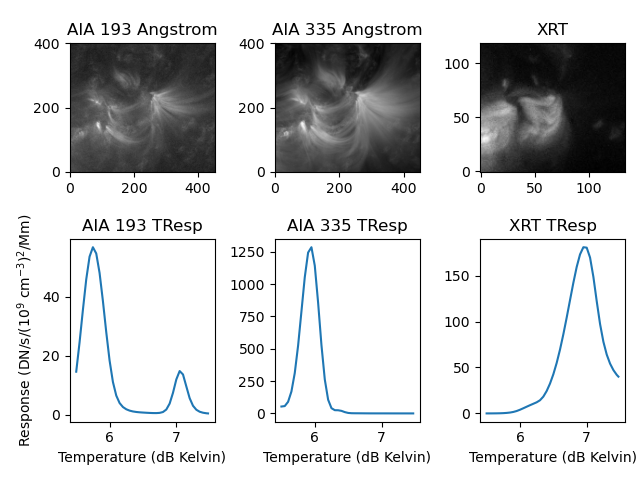

In [8]:
# Show some of the AIA channels and their temperature responses for illustration:

plt_emmax = 5.0e28  # Maximum emission value for plotting
gfac = 1.0 / 2.2  # Gamma correction factor for visualization

fig, axs = plt.subplots(2, 3)  # Create a figure with a 2x3 grid of subplots

# Plot AIA 193 Angstrom channel
axs[0, 0].imshow(np.clip(maps[1].data / np.max(tresps[1]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 0].set(title='AIA 193 Angstrom')
axs[1, 0].plot(trlogts[1], tresps[1] / 1.0e-27)
axs[1, 0].set(title='AIA 193 TResp', xlabel='Temperature (dB Kelvin)', ylabel='Response (DN/s/(10$^9$ cm$^{-3})^2$/Mm)')

# Plot AIA 335 Angstrom channel
axs[0, 1].imshow(np.clip(maps[2].data / np.max(tresps[2]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 1].set(title='AIA 335 Angstrom')
axs[1, 1].plot(trlogts[2], tresps[2] / 1.0e-27)
axs[1, 1].set(title='AIA 335 TResp', xlabel='Temperature (dB Kelvin)')

# Plot AIA 94 Angstrom channel
axs[0, 2].imshow(np.clip(maps[6].data / np.max(tresps[6]), 0, plt_emmax) ** gfac, cmap=plt.get_cmap('gray'))
axs[0, 2].set(title='XRT')
axs[1, 2].plot(trlogts[6], tresps[6] / 1.0e-27)
axs[1, 2].set(title='XRT TResp', xlabel='Temperature (dB Kelvin)')

# Adjust layout and show the plots
plt.tight_layout(); plt.show()

## DEM Analysis

### Compute the Differential Emission Measure

Three algorithms are currently supported. 

In [9]:
coeffs, logts, bases, wcs, name, alg_object = sparse_matrix_dem_wrapper(datasequence,wrapargs={'norms':norms, 'overall_norm':overall_norm})
matrix_multi_em_sequence = emtk.dem_model(coeffs, logts, bases, wcs, name, alg_object, meta=None)
em_collection.add_model(matrix_multi_em_sequence)

Running on image 1 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:42<00:00, 1890.44it/s]


Running on image 2 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:44<00:00, 1849.88it/s]


Running on image 3 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:41<00:00, 1905.58it/s]


Running on image 4 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:43<00:00, 1876.19it/s]


Running on image 5 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:41<00:00, 1905.26it/s]


Running on image 6 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:42<00:00, 1888.03it/s]


Running on image 7 of 7


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 193390/193390 [01:42<00:00, 1889.90it/s]


81815.59726998078 1479.2008287092985 0.0 11.691603046868762
Overall regularization factor: 1.0


Iteration:  10%|████████████████                                                                                                                                                 | 1/10 [02:21<21:09, 141.06s/it]

141.06 s i = 0 chi2 = 110.91 step size = 0.3 reg. param. = 0.1 chi2 change = 124.32324 reg. change = -0.09549
Setup:  1.4751222133636475 Solver:  132.76697778701782 Stepper:  6.8200764656066895
New combined FOM: 111.00499663933908 Old combined FOM: 235.23274633573834 Change: 124.22774969639926


Iteration:  20%|███████████████████████████████▊                                                                                                                               | 2/10 [15:04<1:07:37, 507.19s/it]

904.54 s i = 1 chi2 = 23.46 step size = 0.85 reg. param. = 0.41 chi2 change = 87.4516 reg. change = -0.31642
Setup:  2.897590160369873 Solver:  887.834766626358 Stepper:  13.801802396774292
New combined FOM: 23.869811955104854 Old combined FOM: 111.00499663933908 Change: 87.13518468423423


Iteration:  30%|███████████████████████████████████████████████▋                                                                                                               | 3/10 [25:38<1:05:54, 564.90s/it]

1538.11 s i = 2 chi2 = 4.37 step size = 0.85 reg. param. = 0.62 chi2 change = 19.0858 reg. change = -0.20792
Setup:  4.2947423458099365 Solver:  1512.5732972621918 Stepper:  21.238484859466553
New combined FOM: 4.99193302187891 Old combined FOM: 23.869811955104854 Change: 18.877878933225944


Iteration:  40%|████████████████████████████████████████████████████████████████▍                                                                                                | 4/10 [34:04<54:11, 541.88s/it]

2044.7 s i = 3 chi2 = 1.18 step size = 0.85 reg. param. = 0.7 chi2 change = 3.19159 reg. change = -0.07905
Setup:  5.702732086181641 Solver:  2009.9206957817078 Stepper:  29.065661907196045
New combined FOM: 1.8793848983758705 Old combined FOM: 4.99193302187891 Change: 3.112548123503039


Iteration:  40%|████████████████████████████████████████████████████████████████▍                                                                                                | 4/10 [36:52<55:19, 553.20s/it]

2212.79 s i = 4 chi2 = 0.92 step size = 0.85 reg. param. = 0.69 chi2 change = 0.25927 reg. change = 0.00786
Setup:  7.0874974727630615 Solver:  2169.4973526000977 Stepper:  36.1956672668457
New combined FOM: 1.6122555295136274 Old combined FOM: 1.8793848983758705 Change: 0.26712936886224314


### Run the Dashboard

In [15]:
# Get the most recent version from the tool kit:
importlib.reload(EMToolKit.visualization.dashboard)
from EMToolKit.visualization.dashboard import dashboard_object

# Suppress specific SunpyMetadataWarning
import warnings
from sunpy.util.exceptions import SunpyMetadataWarning
warnings.filterwarnings("ignore", category=SunpyMetadataWarning)

Output()

Click on the image to populate the dashboard


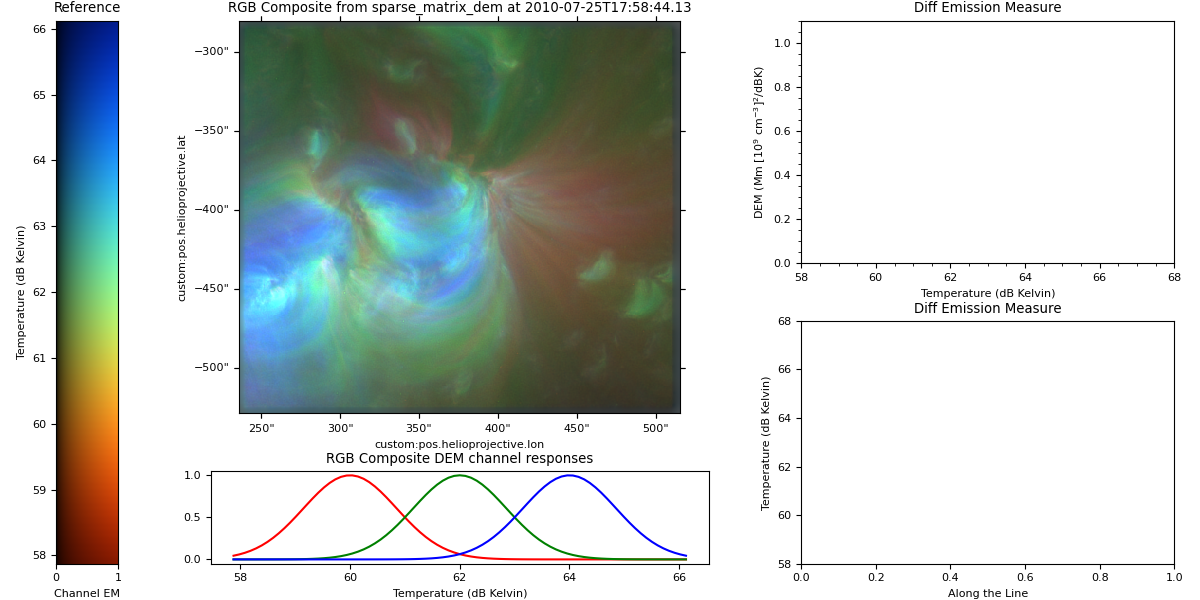

In [18]:
# Create the dashboard:
dash = dashboard_object(em_collection, xsize=12, ysize=6, fontsize=8)
dash.display(True)